In [2]:
import sys
print(sys.executable)


D:\PROJECT\UIDAI hackathon\.venv\Scripts\python.exe


In [1]:
import pandas as pd
import glob
import os

BIOMETRIC_PATH = r"D:\PROJECT\UIDAI hackathon\data\api_data_aadhar_biometric"

# Get all CSV files
files = glob.glob(os.path.join(BIOMETRIC_PATH, "*.csv"))

print(f"Found {len(files)} files")

# Load and merge all parts
dfs = []
for f in files:
    print("Loading:", os.path.basename(f))
    df = pd.read_csv(f)
    dfs.append(df)

biometric_df = pd.concat(dfs, ignore_index=True)

print("\nFinal Biometric DF Shape:", biometric_df.shape)

# Inspect data
display(biometric_df.head())
print("\nColumns:")
print(list(biometric_df.columns))

print("\nInfo:")
biometric_df.info()


Found 4 files
Loading: api_data_aadhar_biometric_0_500000.csv
Loading: api_data_aadhar_biometric_1000000_1500000.csv
Loading: api_data_aadhar_biometric_1500000_1861108.csv
Loading: api_data_aadhar_biometric_500000_1000000.csv

Final Biometric DF Shape: (1861108, 6)


,date,state,district,pincode,bio_age_5_17,bio_age_17_
0,01-03-2025,Haryana,Mahendragarh,123029,280,577
1,01-03-2025,Bihar,Madhepura,852121,144,369
2,01-03-2025,Jammu and Kashmir,Punch,185101,643,1091
3,01-03-2025,Bihar,Bhojpur,802158,256,980
4,01-03-2025,Tamil Nadu,Madurai,625514,271,815



Columns:
['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1861108 entries, 0 to 1861107
Data columns (total 6 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   date          object
 1   state         object
 2   district      object
 3   pincode       int64 
 4   bio_age_5_17  int64 
 5   bio_age_17_   int64 
dtypes: int64(3), object(3)
memory usage: 85.2+ MB


Step 1 Convert Date & Add Time Features

In [7]:
# Convert date column to datetime
biometric_df['date'] = pd.to_datetime(biometric_df['date'], errors='coerce')

# Check min and max date
print("Date range:", biometric_df['date'].min(), "to", biometric_df['date'].max())

# Create year and month columns
biometric_df['year'] = biometric_df['date'].dt.year
biometric_df['month'] = biometric_df['date'].dt.month

biometric_df.head()
#print("\nFinal Biometric DF Shape:", biometric_df.shape)

Date range: 2025-01-03 00:00:00 to 2025-12-12 00:00:00


,date,state,district,pincode,bio_age_5_17,bio_age_17_,year,month
0,2025-01-03,Haryana,Mahendragarh,123029,280,577,2025.0,1.0
1,2025-01-03,Bihar,Madhepura,852121,144,369,2025.0,1.0
2,2025-01-03,Jammu and Kashmir,Punch,185101,643,1091,2025.0,1.0
3,2025-01-03,Bihar,Bhojpur,802158,256,980,2025.0,1.0
4,2025-01-03,Tamil Nadu,Madurai,625514,271,815,2025.0,1.0


In [8]:
biometric_df['date'].isna().sum()


np.int64(944100)

In [10]:
biometric_df = biometric_df.dropna(subset=['date'])


In [11]:
biometric_df['year'] = biometric_df['date'].dt.year.astype(int)
biometric_df['month'] = biometric_df['date'].dt.month.astype(int)


In [12]:
biometric_df[['date', 'year', 'month']].head()


,date,year,month
0,2025-01-03,2025,1
1,2025-01-03,2025,1
2,2025-01-03,2025,1
3,2025-01-03,2025,1
4,2025-01-03,2025,1


In [13]:
monthly_updates = biometric_df.groupby('month')[['bio_age_5_17', 'bio_age_17_']].sum().sort_index()
monthly_updates


,bio_age_5_17,bio_age_17_
month,,
1,20827015,22937341
2,666600,593410
3,563950,576240
4,512443,526938
5,389715,428201
6,533374,500666
7,315285,322315
8,552308,560107
9,559539,548019


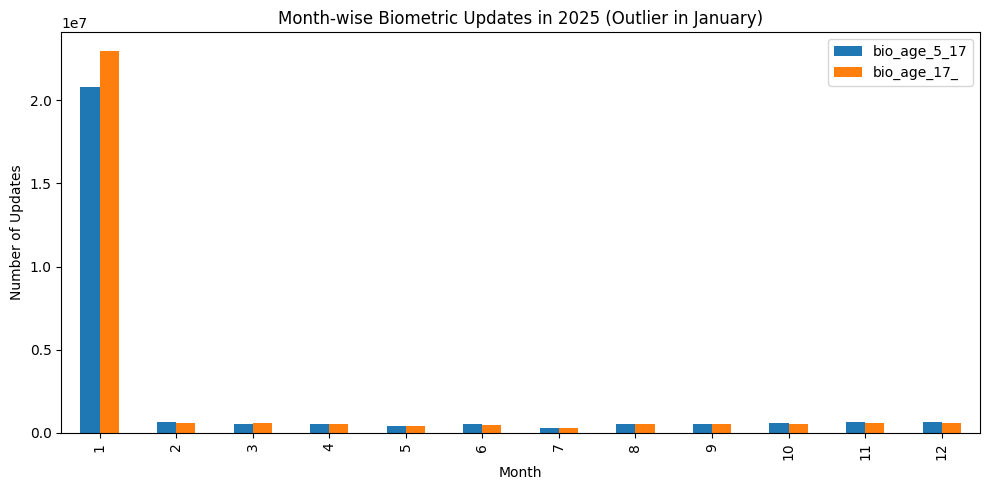

In [14]:
import matplotlib.pyplot as plt

monthly_updates.plot(kind='bar', figsize=(10,5))
plt.title("Month-wise Biometric Updates in 2025 (Outlier in January)")
plt.ylabel("Number of Updates")
plt.xlabel("Month")
plt.tight_layout()
plt.show()


In [16]:
jan_data = biometric_df[biometric_df['month'] == 1]

jan_state = jan_data.groupby('state')[['bio_age_5_17', 'bio_age_17_']].sum().sort_values(by='bio_age_17_', ascending=False)

jan_state.head(10)


,bio_age_5_17,bio_age_17_
state,,
Maharashtra,1738826,3407643
Uttar Pradesh,3864019,2055116
Madhya Pradesh,2385083,1873884
Bihar,1547373,1726934
Tamil Nadu,1212984,1633833
Gujarat,1028050,1234349
Rajasthan,1040427,1229606
Chhattisgarh,324951,1162349
Karnataka,796231,912181


In [17]:
jan_state.head(10)

,bio_age_5_17,bio_age_17_
state,,
Maharashtra,1738826,3407643
Uttar Pradesh,3864019,2055116
Madhya Pradesh,2385083,1873884
Bihar,1547373,1726934
Tamil Nadu,1212984,1633833
Gujarat,1028050,1234349
Rajasthan,1040427,1229606
Chhattisgarh,324951,1162349
Karnataka,796231,912181


Step 2: Basic Aggregation Check

In [18]:
# Total updates per year
yearly_updates = biometric_df.groupby('year')[['bio_age_5_17', 'bio_age_17_']].sum()

yearly_updates


,bio_age_5_17,bio_age_17_
year,,
2025,26789009,28757284


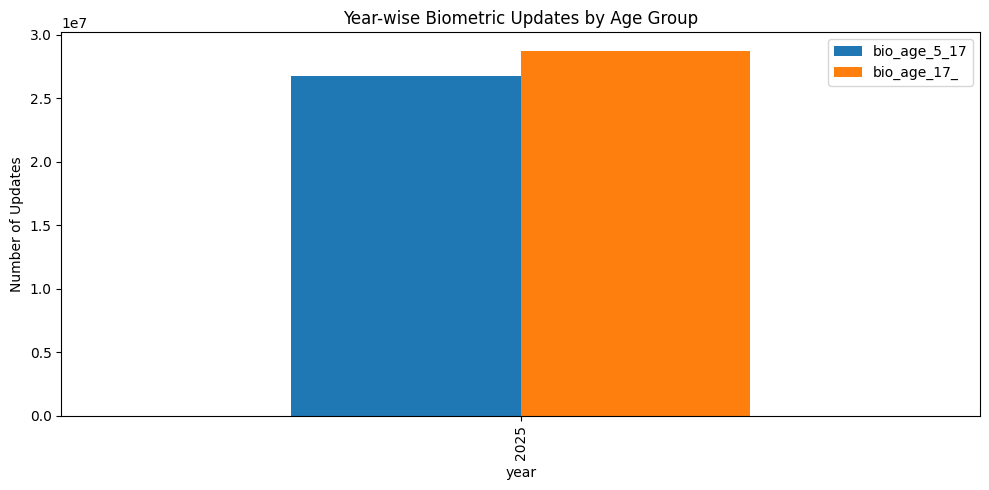

In [19]:
import matplotlib.pyplot as plt

yearly_updates.plot(kind='bar', figsize=(10,5))

























plt.title("Year-wise Biometric Updates by Age Group")
plt.ylabel("Number of Updates")
plt.tight_layout()
plt.show()


In [20]:
# We know January has an abnormal spike.
# So first, we filter the main biometric dataframe to only January data.

jan_data = biometric_df[biometric_df['month'] == 1]

# Check how many rows belong to January
print("Rows in January data:", len(jan_data))

# Quick look at January data
jan_data.head()


Rows in January data: 180478


,date,state,district,pincode,bio_age_5_17,bio_age_17_,year,month
0,2025-01-03,Haryana,Mahendragarh,123029,280,577,2025,1
1,2025-01-03,Bihar,Madhepura,852121,144,369,2025,1
2,2025-01-03,Jammu and Kashmir,Punch,185101,643,1091,2025,1
3,2025-01-03,Bihar,Bhojpur,802158,256,980,2025,1
4,2025-01-03,Tamil Nadu,Madurai,625514,271,815,2025,1


In [21]:
# Now we group January data by STATE
# and sum up biometric updates for both age groups

jan_state = (
    jan_data
    .groupby('state')[['bio_age_5_17', 'bio_age_17_']]
    .sum()
)

# Create a new column for total updates (both age groups combined)
jan_state['total_updates'] = jan_state['bio_age_5_17'] + jan_state['bio_age_17_']

# Sort states by total updates in descending order
jan_state = jan_state.sort_values(by='total_updates', ascending=False)

# Show top 10 states contributing to January spike
jan_state.head(10)


,bio_age_5_17,bio_age_17_,total_updates
state,,,
Uttar Pradesh,3864019,2055116,5919135
Maharashtra,1738826,3407643,5146469
Madhya Pradesh,2385083,1873884,4258967
Bihar,1547373,1726934,3274307
Tamil Nadu,1212984,1633833,2846817
Andhra Pradesh,1540422,875185,2415607
Rajasthan,1040427,1229606,2270033
Gujarat,1028050,1234349,2262399
Karnataka,796231,912181,1708412


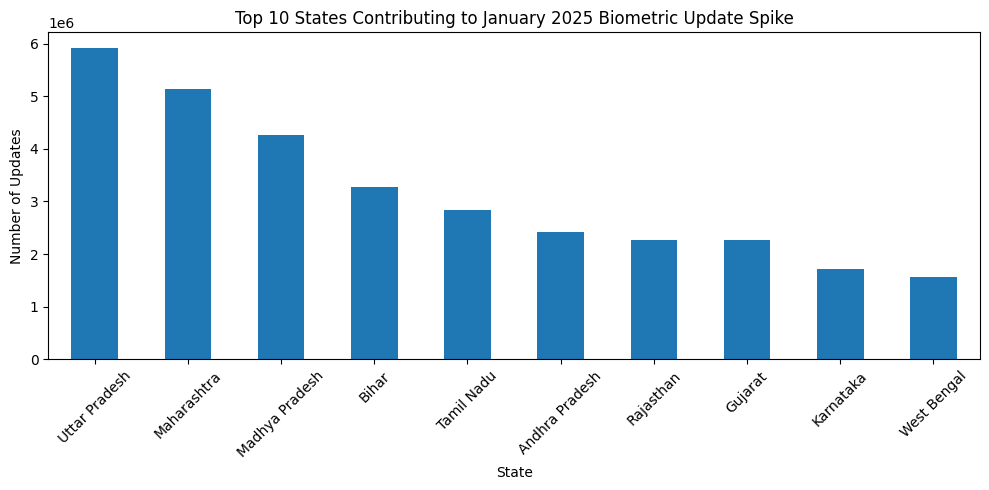

In [22]:
import matplotlib.pyplot as plt

# Take top 10 states only
top10_states = jan_state.head(10)

# Plot bar chart
top10_states['total_updates'].plot(kind='bar', figsize=(10,5))

plt.title("Top 10 States Contributing to January 2025 Biometric Update Spike")
plt.ylabel("Number of Updates")
plt.xlabel("State")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [23]:
# Let's find which state is number 1
top_state = jan_state.index[0]
print("Top contributing state in January:", top_state)

# Filter January data for only this top state
top_state_data = jan_data[jan_data['state'] == top_state]

# Group by district inside this state
district_analysis = (
    top_state_data
    .groupby('district')[['bio_age_5_17', 'bio_age_17_']]
    .sum()
)

# Create total updates column
district_analysis['total_updates'] = (
    district_analysis['bio_age_5_17'] + district_analysis['bio_age_17_']
)

# Sort districts by total updates
district_analysis = district_analysis.sort_values(by='total_updates', ascending=False)

# Show top 10 districts of that state
district_analysis.head(10)


Top contributing state in January: Uttar Pradesh


,bio_age_5_17,bio_age_17_,total_updates
district,,,
Sitapur,136524,40105,176629
Allahabad,121376,48609,169985
Agra,98764,52953,151717
Bareilly,107931,39043,146974
Bijnor,93779,44493,138272
Lucknow,76330,59983,136313
Aligarh,95301,33752,129053
Ghaziabad,68287,59784,128071
Hardoi,92231,33332,125563


In [26]:
# Clean state names
biometric_df['state'] = biometric_df['state'].str.strip().str.title()


In [29]:
state_yearly = (
    biometric_df
    .groupby('state')[['bio_age_5_17', 'bio_age_17_']]
    .sum()
)

state_yearly['total_updates'] = state_yearly['bio_age_5_17'] + state_yearly['bio_age_17_']
state_yearly['child_ratio'] = state_yearly['bio_age_5_17'] / state_yearly['total_updates']

state_yearly_sorted = state_yearly.sort_values(by='child_ratio', ascending=False)

state_yearly_sorted.head(10)


,bio_age_5_17,bio_age_17_,total_updates,child_ratio
state,,,,
Mizoram,77102,31243,108345,0.711634
Chandigarh,44947,21449,66396,0.676953
Uttar Pradesh,4841142,2664112,7505254,0.645034
Assam,452216,254909,707125,0.639514
Andhra Pradesh,1796112,1139915,2936027,0.611749
Daman And Diu,3274,2086,5360,0.610821
Andaman And Nicobar Islands,8847,5980,14827,0.596682
Manipur,122104,91997,214101,0.570310
Arunachal Pradesh,31779,25040,56819,0.559302


In [27]:
# Group by state for the whole year
state_yearly = (
    biometric_df
    .groupby('state')[['bio_age_5_17', 'bio_age_17_']]
    .sum()
)

# Compute total and ratio
state_yearly['total_updates'] = state_yearly['bio_age_5_17'] + state_yearly['bio_age_17_']
state_yearly['child_ratio'] = state_yearly['bio_age_5_17'] / state_yearly['total_updates']

# Sort by child ratio
state_yearly_sorted = state_yearly.sort_values(by='child_ratio', ascending=False)

# Show top 10 states where child updates dominate
state_yearly_sorted.head(10)


,bio_age_5_17,bio_age_17_,total_updates,child_ratio
state,,,,
Mizoram,77102,31243,108345,0.711634
Chandigarh,44947,21449,66396,0.676953
Uttar Pradesh,4841142,2664112,7505254,0.645034
Assam,452216,254909,707125,0.639514
Andhra Pradesh,1796112,1139915,2936027,0.611749
Daman And Diu,3274,2086,5360,0.610821
Andaman And Nicobar Islands,8847,5980,14827,0.596682
Manipur,122104,91997,214101,0.570310
Arunachal Pradesh,31779,25040,56819,0.559302


In [30]:
# Keep only states with significant data
filtered_states = state_yearly_sorted[state_yearly_sorted['total_updates'] > 100_000]

filtered_states.head(10)


,bio_age_5_17,bio_age_17_,total_updates,child_ratio
state,,,,
Mizoram,77102,31243,108345,0.711634
Uttar Pradesh,4841142,2664112,7505254,0.645034
Assam,452216,254909,707125,0.639514
Andhra Pradesh,1796112,1139915,2936027,0.611749
Manipur,122104,91997,214101,0.570310
Madhya Pradesh,2778089,2278871,5056960,0.549359
Telangana,673840,615497,1289337,0.522625
Uttarakhand,286429,265837,552266,0.518643
Tripura,126754,121502,248256,0.510578


In [36]:
import os

os.makedirs("outputs", exist_ok=True)


In [39]:
BASE_DIR = r"D:\PROJECT\UIDAI hackathon"

OUTPUT_DIR = os.path.join(BASE_DIR, "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

filtered_states.to_csv(
    os.path.join(OUTPUT_DIR, "biometric_child_ratio_by_state.csv"),
    index_label="state"
)


In [38]:
filtered_states.to_csv(
    "outputs/biometric_child_ratio_by_state.csv",
    index_label="state"
)
